# mini test

In [1]:
# 1.세팅
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import json

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
torch_dtype = torch.float32
print("------------------ Setup Check ------------------")
print("Using device:", device)
print("Using torch_dtype:", torch_dtype)

# 2.모델 로드
model_id = "microsoft/Florence-2-large"

# print("Loading Florence-2 Large model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

# 3.테스트 데이터 로드
image_path = "./data/test01_re.JPG"
image = Image.open(image_path).convert("RGB")

##################### 4. 작성중
task_prompt = "<OCR_WITH_REGION>"
text_input=None

if text_input is None:
        prompt = task_prompt
else:
    prompt = task_prompt + text_input

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=4096,
        num_beams=3,
        do_sample=False,
        early_stopping=True
    )
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(
    	generated_text,
    	task=task_prompt,
    	image_size=(image.width, image.height)
	)

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------ Setup Check ------------------
Using device: cuda:0
Using torch_dtype: torch.float32


In [2]:
print(generated_text)

</s><s>1<loc_439><loc_69><loc_458><loc_69><loc_458><loc_86><loc_439><loc_86>NO.1 SINTER MAIN 이가지 2F<loc_302><loc_124><loc_948><loc_124><loc_948><loc_158><loc_302><loc_158>A<loc_84><loc_192><loc_110><loc_192><loc_110><loc_211><loc_84><loc_211>H1B1-714-SL02-001<loc_544><loc_254><loc_812><loc_254><loc_812><loc_275><loc_544><loc_275>12월 오크 아화리기<loc_544><loc_281><loc_780><loc_281><loc_780><loc_302><loc_544><loc_302>ACB PANEL (갈정)<loc_544><loc_309><loc_761><loc_309><loc_761><loc_334><loc_544><loc_334>B<loc_84><loc_612><loc_110><loc_612><loc_110><loc_631><loc_84><loc_631></s>


In [3]:
parsed_answer = processor.post_process_generation(
    	generated_text,
    	task=task_prompt,
    	image_size=(image.width, image.height)
	)

In [ ]:
import supervision as sv

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, parsed_answer, resolution_wh=image.size)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [6]:
# # 26버전
# box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
# label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

# annotated = box_annotator.annotate(image, detections=detections)
# annotated = label_annotator.annotate(annotated, detections=detections)
# sv.plot_image(annotated)

In [18]:
for idx,text in enumerate(detections.data['class_name']) :
    print(f'{idx+1} : {text}')

1 : </s>1
2 : NO.1 SINTER MAIN 이가지 2F
3 : A
4 : H1B1-714-SL02-001
5 : 12월 오크 아화리기
6 : ACB PANEL (갈정)
7 : B


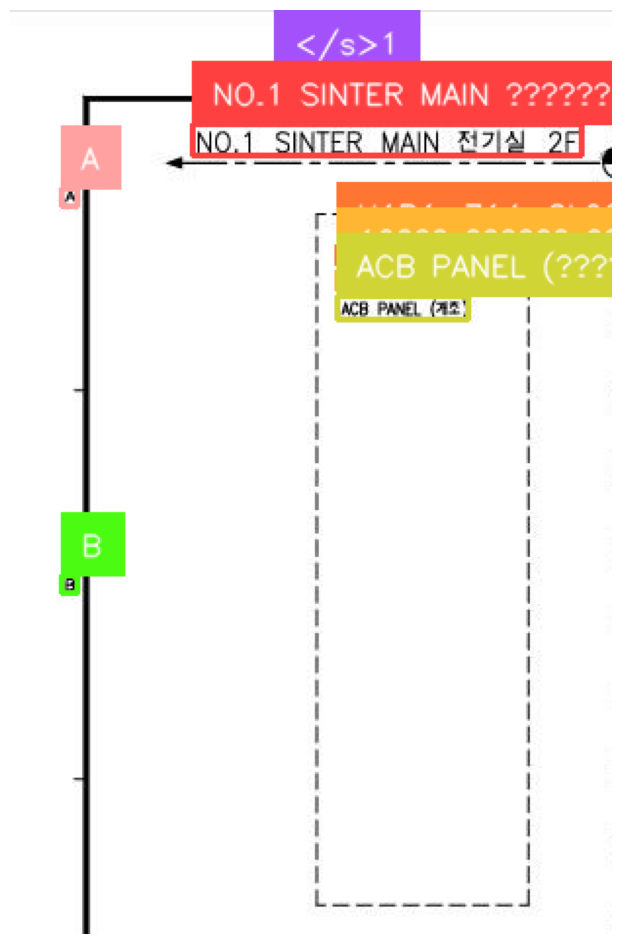

In [7]:
annotated = bounding_box_annotator.annotate(image, detections=detections)
annotated = label_annotator.annotate(annotated, detections=detections)
sv.plot_image(annotated)